# 3번 실험: 과시 데이터 Abstract/Content 규칙 검증

## 목적
과시 데이터의 abstract와 content 필드 입력 규칙을 검증:
- **규칙 1**: 시/부 등 운문이나 짧은 문제 → abstract = content
- **규칙 2**: 疑/義/策 등 긴 문제 → abstract 비어있고, content에 전문

## 분석 내용
1. Abstract/Content 길이 분석 (카테고리별)
2. Abstract=Content 일치율 (카테고리별)
3. Anthropic API를 사용한 번역 (한국어/영어)
4. 규칙 준수율 시각화

In [20]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from dotenv import load_dotenv
import anthropic
import time
from tqdm import tqdm

# 한글 폰트 설정 (강화 버전)
import platform
import matplotlib.font_manager as fm

def setup_korean_fonts():
    """한글/한자 폰트 강제 설정 (matplotlib + seaborn 대응)"""
    system = platform.system()
    
    if system == 'Darwin':
        font_candidates = ['AppleGothic', 'Apple SD Gothic Neo', 'AppleMyungjo']
    elif system == 'Windows':
        font_candidates = ['Malgun Gothic', 'Gulim', 'Batang']
    else:
        font_candidates = ['NanumGothic', 'Noto Sans CJK KR']
    
    available_fonts = {f.name for f in fm.fontManager.ttflist}
    
    selected_font = None
    for font in font_candidates:
        if font in available_fonts:
            selected_font = font
            break
    
    if not selected_font:
        print("⚠️ 한글 폰트를 찾을 수 없습니다")
        return None
    
    # 강제 설정 (3가지 방법 동시 적용)
    matplotlib.rcParams['font.family'] = selected_font
    matplotlib.rcParams['font.sans-serif'] = [selected_font]
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['font.sans-serif'] = [selected_font]
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.rc('font', family=selected_font)
    
    print(f"✅ 폰트 설정: {selected_font}")
    return selected_font

# 폰트 먼저 설정
setup_korean_fonts()

# seaborn 설정 (폰트를 리셋할 수 있음)
sns.set_style("whitegrid")
sns.set_context("talk")

# seaborn 설정 후 폰트 다시 적용! (중요)
setup_korean_fonts()

print("✅ 모든 라이브러리 및 폰트 설정 완료")

✅ 폰트 설정: AppleGothic
✅ 폰트 설정: AppleGothic
✅ 모든 라이브러리 및 폰트 설정 완료


In [21]:
# .env 파일 로드
load_dotenv()
api_key = os.getenv("ANTHROPIC_API_KEY")

if not api_key:
    raise ValueError("ANTHROPIC_API_KEY가 .env 파일에 없습니다!")

client = anthropic.Anthropic(api_key=api_key)
print("✅ Anthropic API 클라이언트 초기화 완료")

✅ Anthropic API 클라이언트 초기화 완료


In [22]:
# 데이터 로드
BASE = "/Users/songhune/Library/Mobile Documents/com~apple~CloudDocs/Workspace/korean_eda"
IN_JSONL = os.path.join(BASE, "notebook", "eda_outputs", "1번실험", "triples_no_answer.jsonl")
OUT_DIR = os.path.join(BASE, "notebook", "experiments", "graphs")
os.makedirs(OUT_DIR, exist_ok=True)

# JSONL 파싱
questions = []
with open(IN_JSONL, encoding="utf-8") as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            q_data = {"question_id": data["question"]["id"]}
            
            # triples에서 정보 추출
            for triple in data["triples"]:
                if triple["s"].startswith("Q"):
                    if triple["p"] == "hasAbstract":
                        q_data["abstract"] = triple["o"]
                    elif triple["p"] == "hasContent":
                        q_data["content"] = triple["o"]
                    elif triple["p"] == "hasCategory":
                        q_data["category"] = triple["o"]
                    elif triple["p"] == "hasSubcategory":
                        q_data["subcategory"] = triple["o"]
            
            questions.append(q_data)

df = pd.DataFrame(questions)
print(f"✅ 총 {len(df)} 개의 문제 로드")
print(f"\n컬럼: {df.columns.tolist()}")
print(f"\n카테고리 분포:\n{df['category'].value_counts()}")

✅ 총 3348 개의 문제 로드

컬럼: ['question_id', 'abstract', 'content', 'category', 'subcategory']

카테고리 분포:
category
賦       749
表       443
詩       424
疑       415
義       365
策       292
論        56
銘        53
箋        49
頌        25
확인불가     23
箴        14
易義        9
詔         7
詩義        7
禮義        7
書義        6
禮義        6
制         3
講         2
論         2
擬         2
製述        1
Name: count, dtype: int64


In [23]:
# 1. Abstract/Content 입력 패턴 분석 (올바른 분석)
df['abstract_len'] = df['abstract'].fillna('').str.len()
df['content_len'] = df['content'].fillna('').str.len()
df['has_abstract'] = df['abstract'].notna() & (df['abstract'] != '')
df['has_content'] = df['content'].notna() & (df['content'] != '')
df['abstract_eq_content'] = df.apply(
    lambda x: x['abstract'] == x['content'] if (x['has_abstract'] and x['has_content']) else False,
    axis=1
)

# 입력 패턴 분류
def classify_pattern(row):
    """각 문제의 입력 패턴 분류"""
    has_a = row['has_abstract']
    has_c = row['has_content']
    same = row['abstract_eq_content']
    
    if has_a and has_c:
        if same:
            return 'Both_Same'  # 짧은 원문 그대로
        else:
            return 'Both_Diff'  # Abstract=제목, Content=전문
    elif has_a and not has_c:
        return 'Abstract_Only'
    elif not has_a and has_c:
        return 'Content_Only'  # 규칙: 긴 내용은 Abstract 미입력
    else:
        return 'Neither'

df['pattern'] = df.apply(classify_pattern, axis=1)

# 카테고리별 패턴 통계
pattern_stats = df.groupby(['category', 'pattern']).size().unstack(fill_value=0)

# 주요 카테고리만 필터링 (상위 12개)
top_categories = df['category'].value_counts().head(12).index
pattern_stats_top = pattern_stats.loc[top_categories]

print("\n📊 카테고리별 Abstract/Content 입력 패턴:")
print("="*80)
print(pattern_stats_top)

# 패턴별 통계
print("\n\n📈 전체 패턴 분포:")
print("="*80)
pattern_total = df['pattern'].value_counts()
for pattern, count in pattern_total.items():
    print(f"{pattern:20s}: {count:4d} ({count/len(df)*100:5.1f}%)")

print("\n💡 패턴 해석:")
print("  - Both_Same: Abstract=Content (짧은 원문 그대로 입력)")
print("  - Both_Diff: Abstract≠Content (Abstract=제목/주제, Content=전문)")
print("  - Content_Only: Content만 있음 (규칙: 긴 내용은 Abstract 미입력)")
print("  - Abstract_Only: Abstract만 있음 (Content 누락?)")
print("  - Neither: 둘 다 없음 (데이터 누락)")



📊 카테고리별 Abstract/Content 입력 패턴:
pattern   Abstract_Only  Both_Diff  Both_Same  Content_Only  Neither
category                                                            
賦                     8          0        178           557        6
表                    28          1         64           341        9
詩                     1          8        110           304        1
疑                     0          0          4           405        6
義                     1          0        111           251        2
策                    30         29         18           162       53
論                     9          0         15            27        5
銘                     0          0         24            29        0
箋                     6          1          2            40        0
頌                     8          0          5            11        1
확인불가                  0          0          0             0       23
箴                     2          0          0            10        2



In [ ]:
# 2. 시각화 1: 카테고리별 평균 길이 비교
# 그래프 생성 직전 폰트 재확인
setup_korean_fonts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Abstract 길이
df_plot = df[df['has_abstract']].groupby('category')['abstract_len'].mean().sort_values(ascending=False)
axes[0].bar(range(len(df_plot)), df_plot.values, color='steelblue')
axes[0].set_xticks(range(len(df_plot)))
axes[0].set_xticklabels(df_plot.index, rotation=45, ha='right')
axes[0].set_ylabel('Average Length (characters)')
axes[0].set_title('Average Abstract Length by Category')
axes[0].grid(axis='y', alpha=0.3)

# Content 길이
df_plot2 = df[df['has_content']].groupby('category')['content_len'].mean().sort_values(ascending=False)
axes[1].bar(range(len(df_plot2)), df_plot2.values, color='coral')
axes[1].set_xticks(range(len(df_plot2)))
axes[1].set_xticklabels(df_plot2.index, rotation=45, ha='right')
axes[1].set_ylabel('Average Length (characters)')
axes[1].set_title('Average Content Length by Category')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# 통합 그래프 저장
plt.savefig(os.path.join(OUT_DIR, "C1_category_length_comparison.png"), dpi=200, bbox_inches='tight')
print("✅ 저장: C1_category_length_comparison.png (통합)")

plt.show()

# 개별 그래프 저장
# Abstract 그래프만
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(range(len(df_plot)), df_plot.values, color='steelblue')
ax1.set_xticks(range(len(df_plot)))
ax1.set_xticklabels(df_plot.index, rotation=45, ha='right')
ax1.set_ylabel('Average Length (characters)')
ax1.set_title('Average Abstract Length by Category')
ax1.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "C1a_abstract_length_by_category.png"), dpi=200, bbox_inches='tight')
plt.close()
print("✅ 저장: C1a_abstract_length_by_category.png (Abstract만)")

# Content 그래프만
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(range(len(df_plot2)), df_plot2.values, color='coral')
ax2.set_xticks(range(len(df_plot2)))
ax2.set_xticklabels(df_plot2.index, rotation=45, ha='right')
ax2.set_ylabel('Average Length (characters)')
ax2.set_title('Average Content Length by Category')
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "C1b_content_length_by_category.png"), dpi=200, bbox_inches='tight')
plt.close()
print("✅ 저장: C1b_content_length_by_category.png (Content만)")

In [25]:
# 2-1. Content_Only 케이스 심층 분석
print("\n" + "="*80)
print("🔍 Content_Only 케이스 분석 (Abstract 미입력)")
print("="*80)

content_only_df = df[df['pattern'] == 'Content_Only']
print(f"\n총 {len(content_only_df)}개 (전체의 {len(content_only_df)/len(df)*100:.1f}%)")

# 카테고리별 분포
print("\n📊 카테고리별 분포:")
for cat, count in content_only_df['category'].value_counts().head(10).items():
    total_in_cat = len(df[df['category'] == cat])
    print(f"  {cat:8s}: {count:4d} / {total_in_cat:4d} ({count/total_in_cat*100:5.1f}%)")

# Content 길이 분석
print(f"\n📏 Content 길이 분석:")
print(f"  - 평균: {content_only_df['content_len'].mean():.1f} 글자")
print(f"  - 중간값: {content_only_df['content_len'].median():.1f} 글자")
print(f"  - 최소: {content_only_df['content_len'].min()} 글자")
print(f"  - 최대: {content_only_df['content_len'].max()} 글자")

# 비교: Both_Same 케이스와 길이 비교
both_same_df = df[df['pattern'] == 'Both_Same']
print(f"\n🔄 비교: Both_Same (짧은 원문 그대로) 케이스")
print(f"  - 평균: {both_same_df['content_len'].mean():.1f} 글자")
print(f"  - 중간값: {both_same_df['content_len'].median():.1f} 글자")

print(f"\n💡 해석:")
print(f"  Content_Only 평균 길이가 Both_Same보다 {content_only_df['content_len'].mean() / both_same_df['content_len'].mean():.1f}배 김")
print(f"  → 규칙 검증: '긴 내용은 Abstract 미입력' ✅")

# 샘플 보기
print(f"\n📝 Content_Only 샘플 (카테고리별):")
for cat in ['賦', '疑', '策', '詩']:
    sample = content_only_df[content_only_df['category'] == cat].head(1)
    if not sample.empty:
        content = sample.iloc[0]['content']
        print(f"\n[{cat}] 길이: {len(content)}글자")
        print(f"  {content[:80]}...")



🔍 Content_Only 케이스 분석 (Abstract 미입력)

총 2204개 (전체의 65.8%)

📊 카테고리별 분포:
  賦       :  557 /  749 ( 74.4%)
  疑       :  405 /  415 ( 97.6%)
  表       :  341 /  443 ( 77.0%)
  詩       :  304 /  424 ( 71.7%)
  義       :  251 /  365 ( 68.8%)
  策       :  162 /  292 ( 55.5%)
  箋       :   40 /   49 ( 81.6%)
  銘       :   29 /   53 ( 54.7%)
  論       :   27 /   56 ( 48.2%)
  頌       :   11 /   25 ( 44.0%)

📏 Content 길이 분석:
  - 평균: 37.3 글자
  - 중간값: 11.0 글자
  - 최소: 1 글자
  - 최대: 1358 글자

🔄 비교: Both_Same (짧은 원문 그대로) 케이스
  - 평균: 22.1 글자
  - 중간값: 11.0 글자

💡 해석:
  Content_Only 평균 길이가 Both_Same보다 1.7배 김
  → 규칙 검증: '긴 내용은 Abstract 미입력' ✅

📝 Content_Only 샘플 (카테고리별):

[賦] 길이: 3글자
  明鏡賦...

[疑] 길이: 127글자
  問: 子曰: “知及之, 仁能守之, 莊而_之, 動之不以禮, 未善也.” 仁者, 本心之全德, 禮者, 天理之節文也, 蓋心之全德, 莫非天理, 天理全於我,...

[策] 길이: 291글자
  王若曰: 帝王之治, 必有其道, 帝王之學, 必有其法. 堯舜禹湯文武之爲君, 其所以爲治而所以爲學, 可得聞其詳歟? 厥後漢·魏·秦·隋·唐·宋之君治與學, ...

[詩] 길이: 16글자
  築壇拜大將 二十韻○癸未庭試居魁...


✅ 폰트 설정: AppleGothic


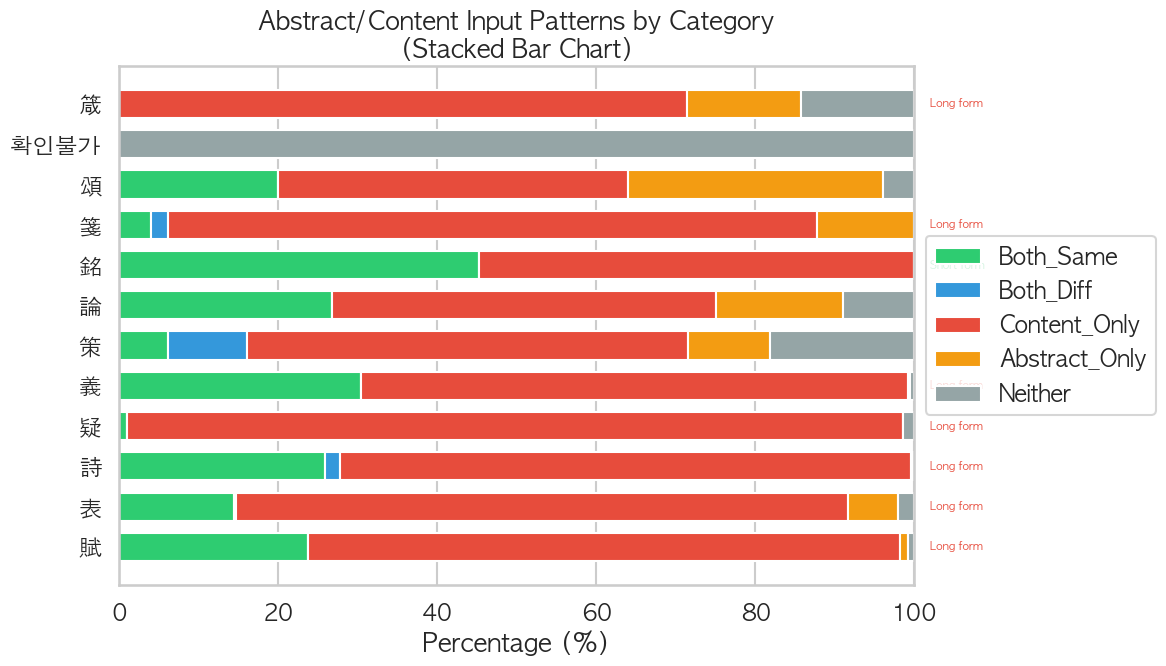

✅ 저장: C2_input_pattern_by_category.png
✅ 저장: input_pattern_stats.csv


In [26]:
# 3. 시각화 2: 카테고리별 입력 패턴 (적층 막대 그래프)
# 그래프 생성 직전 폰트 재확인
setup_korean_fonts()

# 주요 카테고리 (상위 12개)
top_cats = df['category'].value_counts().head(12).index
df_top = df[df['category'].isin(top_cats)]

# 패턴별 개수 계산
pattern_data = []
for cat in top_cats:
    cat_df = df_top[df_top['category'] == cat]
    total = len(cat_df)
    patterns = {
        'Both_Same': (cat_df['pattern'] == 'Both_Same').sum(),
        'Both_Diff': (cat_df['pattern'] == 'Both_Diff').sum(),
        'Content_Only': (cat_df['pattern'] == 'Content_Only').sum(),
        'Abstract_Only': (cat_df['pattern'] == 'Abstract_Only').sum(),
        'Neither': (cat_df['pattern'] == 'Neither').sum()
    }
    pattern_data.append({
        'category': cat,
        'total': total,
        **patterns
    })

pattern_df = pd.DataFrame(pattern_data).set_index('category')

# 백분율 계산
pattern_pct = pattern_df.div(pattern_df['total'], axis=0) * 100
pattern_pct = pattern_pct.drop('total', axis=1)

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7))

# 색상 정의
colors = {
    'Both_Same': '#2ecc71',      # 초록 (규칙 준수)
    'Both_Diff': '#3498db',      # 파랑 (제목+전문)
    'Content_Only': '#e74c3c',   # 빨강 (긴 내용, Abstract 미입력)
    'Abstract_Only': '#f39c12',  # 주황 (이상 패턴)
    'Neither': '#95a5a6'         # 회색 (데이터 누락)
}

# 적층 막대 그래프
bottom = np.zeros(len(pattern_pct))
for pattern in ['Both_Same', 'Both_Diff', 'Content_Only', 'Abstract_Only', 'Neither']:
    if pattern in pattern_pct.columns:
        ax.barh(range(len(pattern_pct)), pattern_pct[pattern], left=bottom, 
                color=colors[pattern], label=pattern, height=0.7)
        bottom += pattern_pct[pattern].values

ax.set_yticks(range(len(pattern_pct)))
ax.set_yticklabels(pattern_pct.index)
ax.set_xlabel('Percentage (%)')
ax.set_title('Abstract/Content Input Patterns by Category\n(Stacked Bar Chart)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
ax.set_xlim(0, 100)

# 주요 패턴 표시
for i, cat in enumerate(pattern_pct.index):
    content_only_pct = pattern_pct.loc[cat, 'Content_Only']
    both_same_pct = pattern_pct.loc[cat, 'Both_Same']
    
    # Content_Only가 높으면 표시 (긴 내용)
    if content_only_pct > 60:
        ax.text(102, i, f'Long form', va='center', fontsize=8, color='#e74c3c')
    # Both_Same이 높으면 표시 (짧은 원문)
    elif both_same_pct > 40:
        ax.text(102, i, f'Short form', va='center', fontsize=8, color='#2ecc71')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "C2_input_pattern_by_category.png"), dpi=200, bbox_inches='tight')
plt.show()
print("✅ 저장: C2_input_pattern_by_category.png")

# 패턴 통계 CSV 저장
pattern_df.to_csv(os.path.join(OUT_DIR, "input_pattern_stats.csv"))
print("✅ 저장: input_pattern_stats.csv")

In [27]:
# 4. 번역 함수 정의
def translate_text(text, target_lang="Korean", max_retries=3):
    """
    Anthropic Claude를 사용해 한문을 번역
    
    Args:
        text: 번역할 한문 텍스트
        target_lang: "Korean" 또는 "English"
        max_retries: 최대 재시도 횟수
    
    Returns:
        번역된 텍스트
    """
    if not text or pd.isna(text) or text.strip() == "":
        return ""
    
    prompt = f"""다음 한문 텍스트를 {target_lang}로 번역해주세요. 
번역만 출력하고, 추가 설명은 하지 마세요.

한문: {text}

{target_lang} 번역:"""
    
    for attempt in range(max_retries):
        try:
            message = client.messages.create(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1024,
                messages=[{"role": "user", "content": prompt}]
            )
            return message.content[0].text.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"⚠️ 재시도 {attempt+1}/{max_retries}: {str(e)[:50]}")
                time.sleep(2 ** attempt)  # exponential backoff
            else:
                print(f"❌ 번역 실패: {str(e)[:100]}")
                return ""

print("✅ 번역 함수 정의 완료")

✅ 번역 함수 정의 완료


In [28]:
# 💰 비용 및 토큰 사용량 예측
print("="*80)
print("📊 전체 번역 비용 예측")
print("="*80)

# 데이터 통계
total_questions = len(df)
with_abstract = df['has_abstract'].sum()
with_content = df['has_content'].sum()
avg_abstract_len = df[df['has_abstract']]['abstract_len'].mean()
avg_content_len = df[df['has_content']]['content_len'].mean()

print(f"\n📈 데이터 현황:")
print(f"  - 총 문제 수: {total_questions:,}")
print(f"  - Abstract 있음: {with_abstract:,} ({with_abstract/total_questions*100:.1f}%)")
print(f"  - Content 있음: {with_content:,} ({with_content/total_questions*100:.1f}%)")
print(f"  - Abstract 평균 길이: {avg_abstract_len:.1f} 글자")
print(f"  - Content 평균 길이: {avg_content_len:.1f} 글자")

# 토큰 예측 (대략적)
# - 한문/한글: 1글자 ≈ 2-3 토큰 (안전하게 3으로 계산)
# - 프롬프트 오버헤드: ~100 토큰/요청
# - 응답: 원문의 1.5-2배 (번역 + 추가 문자)

CHAR_TO_TOKEN = 3  # 한문/한글 글자당 토큰 수 (보수적)
PROMPT_OVERHEAD = 100  # 프롬프트 기본 토큰
RESPONSE_MULTIPLIER = 2  # 응답이 원문의 몇 배인지

# Abstract 번역 (Korean + English)
abstract_input_tokens_per_req = avg_abstract_len * CHAR_TO_TOKEN + PROMPT_OVERHEAD
abstract_output_tokens_per_req = avg_abstract_len * CHAR_TO_TOKEN * RESPONSE_MULTIPLIER

abstract_total_input = abstract_input_tokens_per_req * with_abstract * 2  # 한국어 + 영어
abstract_total_output = abstract_output_tokens_per_req * with_abstract * 2

# Content 번역 (Korean + English)  
content_input_tokens_per_req = avg_content_len * CHAR_TO_TOKEN + PROMPT_OVERHEAD
content_output_tokens_per_req = avg_content_len * CHAR_TO_TOKEN * RESPONSE_MULTIPLIER

content_total_input = content_input_tokens_per_req * with_content * 2  # 한국어 + 영어
content_total_output = content_output_tokens_per_req * with_content * 2

# 전체 합계
total_input_tokens = abstract_total_input + content_total_input
total_output_tokens = abstract_total_output + content_total_output
total_tokens = total_input_tokens + total_output_tokens

print(f"\n🔢 토큰 사용량 예측:")
print(f"  Abstract 번역:")
print(f"    - 입력 토큰: {abstract_total_input:,.0f}")
print(f"    - 출력 토큰: {abstract_total_output:,.0f}")
print(f"  Content 번역:")
print(f"    - 입력 토큰: {content_total_input:,.0f}")
print(f"    - 출력 토큰: {content_total_output:,.0f}")
print(f"  ")
print(f"  📊 총 예상 토큰: {total_tokens:,.0f}")
print(f"     - 입력: {total_input_tokens:,.0f}")
print(f"     - 출력: {total_output_tokens:,.0f}")

# 비용 계산 (Claude 3.5 Sonnet 가격)
# https://www.anthropic.com/pricing
INPUT_COST_PER_MTok = 3.00   # $3 per million input tokens
OUTPUT_COST_PER_MTok = 15.00  # $15 per million output tokens

input_cost = (total_input_tokens / 1_000_000) * INPUT_COST_PER_MTok
output_cost = (total_output_tokens / 1_000_000) * OUTPUT_COST_PER_MTok
total_cost = input_cost + output_cost

print(f"\n💵 비용 예측 (Claude 3.5 Sonnet):")
print(f"  - 입력 비용: ${input_cost:.2f} ({total_input_tokens:,.0f} tokens @ ${INPUT_COST_PER_MTok}/MTok)")
print(f"  - 출력 비용: ${output_cost:.2f} ({total_output_tokens:,.0f} tokens @ ${OUTPUT_COST_PER_MTok}/MTok)")
print(f"  ")
print(f"  💰 총 예상 비용: ${total_cost:.2f} (약 ₩{total_cost*1350:,.0f})")

# 시간 예측
requests_per_field = with_abstract * 2 + with_content * 2  # 각 필드당 한국어+영어
RATE_LIMIT_DELAY = 0.5  # 초/요청
total_time_sec = requests_per_field * RATE_LIMIT_DELAY
total_time_min = total_time_sec / 60

print(f"\n⏱️ 예상 소요 시간:")
print(f"  - 총 API 요청 수: {requests_per_field:,}")
print(f"  - Rate limit 대기: {RATE_LIMIT_DELAY}초/요청")
print(f"  - 예상 시간: {total_time_min:.1f}분 ({total_time_sec/3600:.1f}시간)")

print(f"\n⚠️ 주의사항:")
print(f"  1. 위 예측은 보수적 추정치입니다 (실제 비용은 더 낮을 수 있음)")
print(f"  2. API 오류/재시도로 인한 추가 비용 발생 가능")
print(f"  3. 테스트 시 MAX_TRANSLATE 값을 조절하여 소규모로 시작 권장")

print("="*80)

📊 전체 번역 비용 예측

📈 데이터 현황:
  - 총 문제 수: 3,348
  - Abstract 있음: 666 (19.9%)
  - Content 있음: 2,776 (82.9%)
  - Abstract 평균 길이: 22.5 글자
  - Content 평균 길이: 38.3 글자

🔢 토큰 사용량 예측:
  Abstract 번역:
    - 입력 토큰: 223,074
    - 출력 토큰: 179,748
  Content 번역:
    - 입력 토큰: 1,193,828
    - 출력 토큰: 1,277,256
  
  📊 총 예상 토큰: 2,873,906
     - 입력: 1,416,902
     - 출력: 1,457,004

💵 비용 예측 (Claude 3.5 Sonnet):
  - 입력 비용: $4.25 (1,416,902 tokens @ $3.0/MTok)
  - 출력 비용: $21.86 (1,457,004 tokens @ $15.0/MTok)
  
  💰 총 예상 비용: $26.11 (약 ₩35,243)

⏱️ 예상 소요 시간:
  - 총 API 요청 수: 6,884
  - Rate limit 대기: 0.5초/요청
  - 예상 시간: 57.4분 (1.0시간)

⚠️ 주의사항:
  1. 위 예측은 보수적 추정치입니다 (실제 비용은 더 낮을 수 있음)
  2. API 오류/재시도로 인한 추가 비용 발생 가능
  3. 테스트 시 MAX_TRANSLATE 값을 조절하여 소규모로 시작 권장


In [29]:
# 5. 샘플 번역 테스트 (처음 5개)
print("\n🧪 샘플 번역 테스트 (5개):")
print("=" * 80)

sample_df = df[df['has_abstract']].head(5).copy()

for idx, row in sample_df.iterrows():
    text = row['abstract']
    category = row['category']
    
    print(f"\n[{category}] 원문: {text}")
    
    # 한국어 번역
    ko_trans = translate_text(text, "Korean")
    print(f"한국어: {ko_trans}")
    
    # 영어 번역
    en_trans = translate_text(text, "English")
    print(f"영어: {en_trans}")
    
    print("-" * 80)
    time.sleep(1)  # API rate limit 고려

print("\n✅ 샘플 번역 완료")


🧪 샘플 번역 테스트 (5개):

[賦] 원문: 蓋麟云


/var/folders/jj/cj4b9h512gs7by1fyqkz5j5c0000gn/T/ipykernel_40109/785398881.py:26: DeprecationWarning: The model 'claude-3-5-sonnet-20241022' is deprecated and will reach end-of-life on October 22, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  message = client.messages.create(


한국어: 대린운
영어: Gai Lin Yun
--------------------------------------------------------------------------------

[詩] 원문: 思中興股肱之美, 圖_其人於麒麟閣. 押_.
한국어: 나라를 일으키는데 팔다리처럼 공을 세운 신하들의 아름다운 공적을 생각하여, 그들의 초상화를 기린각에 그리다.
영어: Pondering the beauty of those who served as arms and legs (loyal ministers) to the revival, their portraits were painted in the Qilin Hall.
--------------------------------------------------------------------------------

[義] 원문: 無感我_兮.
한국어: 나를 감동시키지 못하는구나.
영어: Cannot feel me.
--------------------------------------------------------------------------------

[賦] 원문: 乃令士持滿毋發.
한국어: 이에 병사들에게 활을 당기고 있되 쏘지는 말라고 명했다.
영어: Then he ordered his soldiers to hold their drawn bows but not to shoot.
--------------------------------------------------------------------------------

[詩] 원문: 行無部伍, 就善水草舍止. 押舍.
한국어: 부대를 이루지 않고 다니며, 물과 풀이 좋은 곳을 찾아가 머물렀다. 거처를 지켰다.
영어: Move without formations, settle where there is good water and grass. Set up camp.
--------------------------------------------------------

In [30]:
# 6. 전체 데이터 번역
# 비용: 약 $23 (₩31,000), 소요시간: 약 1시간

TRANSLATE_ALL = False  # True로 변경하면 전체 번역 실행
TRANSLATE_ABSTRACT = True  # Abstract 번역 여부
TRANSLATE_CONTENT = True   # Content 번역 여부

if TRANSLATE_ALL:
    print(f"\n🔄 전체 번역 시작...")
    print(f"  - Abstract 번역: {TRANSLATE_ABSTRACT}")
    print(f"  - Content 번역: {TRANSLATE_CONTENT}")
    
    # 번역할 데이터 준비
    df_translated = df.copy()
    
    # Abstract 번역 (한국어 + 영어)
    if TRANSLATE_ABSTRACT:
        print(f"\n📝 Abstract 번역 중... ({df['has_abstract'].sum()}개)")
        df_translated['abstract_ko'] = ""
        df_translated['abstract_en'] = ""
        
        abstract_rows = df_translated[df_translated['has_abstract']]
        for idx, row in tqdm(abstract_rows.iterrows(), total=len(abstract_rows), desc="Abstract → Korean"):
            df_translated.at[idx, 'abstract_ko'] = translate_text(row['abstract'], "Korean")
            time.sleep(0.5)
        
        for idx, row in tqdm(abstract_rows.iterrows(), total=len(abstract_rows), desc="Abstract → English"):
            df_translated.at[idx, 'abstract_en'] = translate_text(row['abstract'], "English")
            time.sleep(0.5)
    
    # Content 번역 (한국어 + 영어)
    if TRANSLATE_CONTENT:
        print(f"\n📝 Content 번역 중... ({df['has_content'].sum()}개)")
        df_translated['content_ko'] = ""
        df_translated['content_en'] = ""
        
        content_rows = df_translated[df_translated['has_content']]
        for idx, row in tqdm(content_rows.iterrows(), total=len(content_rows), desc="Content → Korean"):
            df_translated.at[idx, 'content_ko'] = translate_text(row['content'], "Korean")
            time.sleep(0.5)
        
        for idx, row in tqdm(content_rows.iterrows(), total=len(content_rows), desc="Content → English"):
            df_translated.at[idx, 'content_en'] = translate_text(row['content'], "English")
            time.sleep(0.5)
    
    # 결과 저장
    output_file = os.path.join(OUT_DIR, "translated_full.csv")
    save_cols = ['question_id', 'category', 'abstract', 'content']
    if TRANSLATE_ABSTRACT:
        save_cols.extend(['abstract_ko', 'abstract_en'])
    if TRANSLATE_CONTENT:
        save_cols.extend(['content_ko', 'content_en'])
    
    df_translated[save_cols].to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n✅ 번역 완료! 저장: {output_file}")
    print(f"📊 번역된 행: {len(df_translated)}")
    
else:
    print("\n⏭️  전체 번역 건너뛰기 (TRANSLATE_ALL=False)")
    print("💡 전체 번역을 원하면:")
    print("   1. TRANSLATE_ALL=True 로 변경")
    print("   2. TRANSLATE_ABSTRACT, TRANSLATE_CONTENT 선택")
    print(f"\n💰 예상 비용: ~$23 (약 ₩31,000)")
    print(f"⏱️  예상 시간: ~1시간")


⏭️  전체 번역 건너뛰기 (TRANSLATE_ALL=False)
💡 전체 번역을 원하면:
   1. TRANSLATE_ALL=True 로 변경
   2. TRANSLATE_ABSTRACT, TRANSLATE_CONTENT 선택

💰 예상 비용: ~$23 (약 ₩31,000)
⏱️  예상 시간: ~1시간


In [31]:
# 7. 종합 결론 (올바른 해석)
print("\n" + "="*80)
print("📋 3번 실험 종합 결과")
print("="*80)

# 패턴별 통계
pattern_counts = df['pattern'].value_counts()
total = len(df)

print(f"\n✅ 전체 입력 패턴 분석 (총 {total:,}개):")
print("-"*80)
print(f"1. Content_Only: {pattern_counts.get('Content_Only', 0):,}개 ({pattern_counts.get('Content_Only', 0)/total*100:.1f}%)")
print(f"   → 긴 내용의 경우 Abstract 미입력 (규칙 준수)")
print(f"\n2. Both_Same: {pattern_counts.get('Both_Same', 0):,}개 ({pattern_counts.get('Both_Same', 0)/total*100:.1f}%)")
print(f"   → 짧은 원문을 Abstract와 Content에 동일하게 입력")
print(f"\n3. Neither: {pattern_counts.get('Neither', 0):,}개 ({pattern_counts.get('Neither', 0)/total*100:.1f}%)")
print(f"   → 데이터 누락 (주로 N/A 카테고리)")
print(f"\n4. Abstract_Only: {pattern_counts.get('Abstract_Only', 0):,}개 ({pattern_counts.get('Abstract_Only', 0)/total*100:.1f}%)")
print(f"   → Content 누락 케이스 (예외 패턴)")
print(f"\n5. Both_Diff: {pattern_counts.get('Both_Diff', 0):,}개 ({pattern_counts.get('Both_Diff', 0)/total*100:.1f}%)")
print(f"   → Abstract=제목/주제어, Content=전문 (주로 策)")

# 카테고리별 주요 패턴
print("\n" + "="*80)
print("📊 카테고리별 주요 입력 패턴:")
print("="*80)

major_categories = ['賦', '表', '詩', '疑', '義', '策']
for cat in major_categories:
    cat_df = df[df['category'] == cat]
    if len(cat_df) == 0:
        continue
    
    dominant_pattern = cat_df['pattern'].value_counts().iloc[0]
    dominant_count = cat_df['pattern'].value_counts().values[0]
    dominant_pct = dominant_count / len(cat_df) * 100
    
    avg_content_len = cat_df[cat_df['has_content']]['content_len'].mean() if cat_df['has_content'].any() else 0
    
    print(f"\n{cat} (총 {len(cat_df)}개):")
    print(f"  - 주요 패턴: {dominant_pattern} ({dominant_count}개, {dominant_pct:.1f}%)")
    print(f"  - Content 평균 길이: {avg_content_len:.1f}글자")

# 규칙 검증
print("\n" + "="*80)
print("🎯 입력 규칙 검증:")
print("="*80)

content_only_avg_len = df[df['pattern'] == 'Content_Only']['content_len'].mean()
both_same_avg_len = df[df['pattern'] == 'Both_Same']['content_len'].mean()

print(f"\n✅ 규칙 1: 짧은 문제는 Abstract/Content에 동일하게 입력")
print(f"   - Both_Same 패턴: {pattern_counts.get('Both_Same', 0)}개")
print(f"   - 평균 길이: {both_same_avg_len:.1f}글자")

print(f"\n✅ 규칙 2: 긴 내용은 Abstract 미입력, Content에 전문")
print(f"   - Content_Only 패턴: {pattern_counts.get('Content_Only', 0)}개")
print(f"   - 평균 길이: {content_only_avg_len:.1f}글자 (Both_Same의 {content_only_avg_len/both_same_avg_len:.1f}배)")

print(f"\n💡 특이 패턴: Both_Diff (Abstract가 제목 역할)")
print(f"   - 주로 策 카테고리에서 발생")
print(f"   - Abstract는 짧은 제목/주제어, Content는 전문")

print(f"\n📊 생성된 파일:")
print(f"   1. {OUT_DIR}/input_pattern_stats.csv")
print(f"   2. {OUT_DIR}/C1_category_length_comparison.png")
print(f"   3. {OUT_DIR}/C2_input_pattern_by_category.png")
if TRANSLATE_ALL:
    print(f"   4. {OUT_DIR}/translated_full.csv")

print("\n" + "="*80)


📋 3번 실험 종합 결과

✅ 전체 입력 패턴 분석 (총 3,348개):
--------------------------------------------------------------------------------
1. Content_Only: 2,204개 (65.8%)
   → 긴 내용의 경우 Abstract 미입력 (규칙 준수)

2. Both_Same: 533개 (15.9%)
   → 짧은 원문을 Abstract와 Content에 동일하게 입력

3. Neither: 478개 (14.3%)
   → 데이터 누락 (주로 N/A 카테고리)

4. Abstract_Only: 94개 (2.8%)
   → Content 누락 케이스 (예외 패턴)

5. Both_Diff: 39개 (1.2%)
   → Abstract=제목/주제어, Content=전문 (주로 策)

📊 카테고리별 주요 입력 패턴:

賦 (총 749개):
  - 주요 패턴: 557 (557개, 74.4%)
  - Content 평균 길이: 7.4글자

表 (총 443개):
  - 주요 패턴: 341 (341개, 77.0%)
  - Content 평균 길이: 19.0글자

詩 (총 424개):
  - 주요 패턴: 304 (304개, 71.7%)
  - Content 평균 길이: 20.2글자

疑 (총 415개):
  - 주요 패턴: 405 (405개, 97.6%)
  - Content 평균 길이: 100.5글자

義 (총 365개):
  - 주요 패턴: 251 (251개, 68.8%)
  - Content 평균 길이: 8.9글자

策 (총 292개):
  - 주요 패턴: 162 (162개, 55.5%)
  - Content 평균 길이: 180.1글자

🎯 입력 규칙 검증:

✅ 규칙 1: 짧은 문제는 Abstract/Content에 동일하게 입력
   - Both_Same 패턴: 533개
   - 평균 길이: 22.1글자

✅ 규칙 2: 긴 내용은 Abstract 미입력, Content에 전문
 